In [1]:
import pandas as pd
import numpy as np
import pyteomics.auxiliary as aux
import seaborn as sns
import matplotlib.pyplot as plt
import os, re, subprocess
import ast
#from utility_functions import *

In [2]:
pipeline="fragpipe"
psm_score="analysis_result:peptideprophet_result:parameter:fval"
working_folder = f"/project/def-marie87/vvshazia/pride_reanalysis/analysis_on_groupwalk/hybrid-psm-{pipeline}/"
savefile_path = f'{pipeline}-identified-protein-groups-all-datasets.csv.gz'
PXDs = [
    'PXD002057',
    'PXD005833',
    'PXD014258',
]

SEARCHES = [
    'canon',
    'trembl',
    'openprot',
]
DATASETS = pd.MultiIndex.from_product([PXDs,SEARCHES])
DATASETS

MultiIndex([('PXD002057',    'canon'),
            ('PXD002057',   'trembl'),
            ('PXD002057', 'openprot'),
            ('PXD005833',    'canon'),
            ('PXD005833',   'trembl'),
            ('PXD005833', 'openprot'),
            ('PXD014258',    'canon'),
            ('PXD014258',   'trembl'),
            ('PXD014258', 'openprot')],
           )

In [3]:
def classify_leadprot(x):
    x=x.replace("decoy_","")
    if 'CONTAMINANT' in x.upper():
        return 'Contam'
    elif x.startswith('II_') or x.startswith('IP_'):
        return 'NonCanon'
        # Ensembl is canonical
    else:
        return 'Canon'

def is_peptide_canonical(x):
    '''x is the list of protein classes'''
    if np.array([_=='Contam' for _ in x]).any():
        return 'Contam'
    if np.array([_=='Canon' for _ in x]).any():
        return 'Canonical'
    return 'NonCanonical'

def custom_subgroup_filter(data_,key):
    filtered_subgroups = []
    for (c,m),df in data_.groupby(['isCanonical','isModified']).__iter__():
        tmp = aux.target_decoy.qvalues(df, key=key, reverse=True, is_decoy=df.database=='D',
                                      formula=1, full_output=True, q_label='groupwise_qvalue')
        filtered_subgroups.append(tmp)

    return pd.concat(filtered_subgroups, ignore_index=True)

In [4]:
folders = {search:{dataset_name:[] for dataset_name in PXDs} for search in SEARCHES}
for dataset_name in PXDs:
    for search in SEARCHES:   
        for fld in os.scandir(os.path.join(working_folder, dataset_name, f"{dataset_name}-{search}")):
            if ".csv" in fld.name and not "_Occam" in fld.name:
                folders[search][dataset_name].append(fld)

In [14]:
def get_max_psm_score(x,psms,psm_score):
    protein_group = x.split(',')
    tmp3 = psms[psms.proteins.isin(protein_group)]
    return np.max(tmp3[psm_score])

def group_is_decoy(x):
    protein_group = x.split(',')
    tmp = [_.startswith('decoy') for _ in protein_group]
    return set(tmp)

def classify_protein_group(x):
    protein_group = x.split(',')
    tmp = [classify_leadprot(_) for _ in protein_group]
    return is_peptide_canonical(tmp)

In [12]:
psms[["proteins","protein_classes"]]                                                                                       

,proteins,protein_classes
0,[CH60_HUMAN],['Canon']
1,[K1C18_HUMAN],['Canon']
2,[TBB5_HUMAN],['Canon']
3,"[HS90A_HUMAN, HS90B_HUMAN, HS902_HUMAN]",['Canon']
4,[ENOA_HUMAN],['Canon']
...,...,...
10420,"[K1C19_HUMAN, sp|CONTAMINANT_P08727]",['Canon' 'Contam']
10421,"[K2C7_HUMAN, sp|CONTAMINANT_P08729]",['Canon' 'Contam']
10422,"[K2C8_HUMAN, CONTAMINANT_HIT000292931]",['Canon' 'Contam']
10423,"[K1C18_HUMAN, sp|CONTAMINANT_P05784]",['Canon' 'Contam']


In [15]:
output_files = []
for dataset_name in PXDs:
    for search in SEARCHES:  
        j = len(folders[search][dataset_name])
        for i,sample_fld in enumerate(folders[search][dataset_name]):            
            # Read and preprocess the dataset
            psms = pd.read_csv(os.path.join(sample_fld.path))
            print(f'({1+i}/{j})',sample_fld, psms.shape)
            psms = pd.read_csv(os.path.join(sample_fld.path))
            ##psms.modifications = psms.modifications.fillna('')
            psms = psms[psms['global_q']<=.01].copy(deep=True)
            ##psms.proteins = psms.proteins.str.split('||', regex=False)
            ##psms.proteins = psms.proteins.apply(lambda x: [re.split(r'\(\(|\)\)', _)[3] for _ in x])
            ##psms.proteins = psms.proteins.apply(lambda x: [re.sub(r'^sp\|','',_) for _ in x])
            ##psms.proteins = psms.proteins.apply(lambda x: list(set(x)))
            # try without contaminant peptides
            psms.proteins=psms.proteins.str.split('||', regex=False)
            psms['protein_classes'] = psms.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x]))
            psms['isCanonical'] = psms.protein_classes.apply(is_peptide_canonical)
            ##psms = psms.copy(deep=True)
            ##psms.proteins = psms.apply(lambda row: row.proteins if row.database=='T' else [f'decoy_{_}' for _ in row.proteins] , axis=1)
            # print(psms.proteins.apply(len).describe())

            sample=sample_fld.name.replace(".csv","")
            sample_path=os.path.join(working_folder, dataset_name, f"{dataset_name}-{search}")
            
            with open(os.path.join(sample_path, f"{sample}-protein-inference-input.pout"), 'w') as POUT:
                for _,row in psms[(psms.isCanonical!='Contam')&(psms.proteins.apply(len)<1000)].iterrows():
                    row2 =  [str(row["index"]), row.spectrum, f"{row['global_q']:.2e}", 
                             row.modifications, f"{'n'}.{row.peptide}"] #no charge info
                    row2 += [f'>xx|{_}|placeholder' if '|' not in _ else _ for _ in row.proteins]
                    row2 =  '\t'.join(row2) + '\n'
                    POUT.write(row2)
            
            pout_file = os.path.join(sample_path, f"{sample}-protein-inference-input.pout")
            groups_file = os.path.join(sample_path, f"{sample}-groups_Occam.tsv")
            subgroups_file = os.path.join(sample_path, f"{sample}-subgroups_Occam.tsv")
            _ = subprocess.run(['pout2prot', '--occam', pout_file, groups_file, subgroups_file])
            print('Run pout2prot:',_.returncode==0)  
        
            # Make "summary" table to get max psm score
            psms = psms[['proteins',psm_score]].copy(deep=True)
            psms = psms.explode('proteins')
            psms.sort_values(psm_score, ascending=False, inplace=True)
            psms.drop_duplicates('proteins', inplace=True)
        
            # calculate protein groups scores
            protein_groups = pd.read_csv(groups_file, sep='\t', usecols=['protein accessions'])
            protein_groups.columns = ['proteins']
            protein_groups[psm_score] = protein_groups.proteins.apply(lambda x: get_max_psm_score(x,psms,psm_score))
        
            # label decoys
            protein_groups['isDecoy_'] = protein_groups.proteins.apply(group_is_decoy)
            protein_groups['database'] = protein_groups.isDecoy_.apply(lambda x: 'D' if list(x)[-1] else 'T')
    
            protein_groups = protein_groups[['proteins','database',psm_score]].copy(deep=True)
            protein_groups['experiment'] = sample
            protein_groups['exp_number'] =  f'{dataset_name} exp {i+1}' #'-'.join(sample_fld.name.split('-')[:-1])
            protein_groups['PXD'] = dataset_name
            protein_groups['searchDB'] = search
        
            # recalculate q-values
            protein_groups = aux.target_decoy.qvalues(protein_groups, key=psm_score, reverse=True, 
                                                      is_decoy=protein_groups.database=='D',
                                                      q_label='global_q', formula=1, full_output=True)
        
            protein_groups['isCanonical'] = protein_groups.proteins.apply(classify_protein_group)
            protein_groups['isModified'] = 'NA'
            protein_groups = custom_subgroup_filter(protein_groups,psm_score)
            out_path = os.path.join(sample_path, f"{sample}_protein_groups_Occam.csv")
            protein_groups.to_csv(out_path, index=False)
            output_files.append(out_path)

(1/6) <DirEntry '130327_o2_02_hu_P1_2hr.csv'> (10454, 44)
Run pout2prot: True
(2/6) <DirEntry '130327_o2_05_hu_C3_2hr.csv'> (6580, 44)
Run pout2prot: True
(3/6) <DirEntry '130327_o2_01_hu_C1_2hr.csv'> (7842, 44)
Run pout2prot: True
(4/6) <DirEntry '130327_o2_06_hu_P3_2hr.csv'> (9812, 44)
Run pout2prot: True
(5/6) <DirEntry '130327_o2_04_hu_P2_2hr.csv'> (9546, 44)
Run pout2prot: True
(6/6) <DirEntry '130327_o2_03_hu_C2_2hr.csv'> (6189, 44)
Run pout2prot: True
(1/6) <DirEntry '130327_o2_03_hu_C2_2hr.csv'> (5896, 44)
Run pout2prot: True
(2/6) <DirEntry '130327_o2_04_hu_P2_2hr.csv'> (9165, 44)
Run pout2prot: True
(3/6) <DirEntry '130327_o2_06_hu_P3_2hr.csv'> (9120, 44)
Run pout2prot: True
(4/6) <DirEntry '130327_o2_01_hu_C1_2hr.csv'> (7386, 44)
Run pout2prot: True
(5/6) <DirEntry '130327_o2_05_hu_C3_2hr.csv'> (6221, 44)
Run pout2prot: True
(6/6) <DirEntry '130327_o2_02_hu_P1_2hr.csv'> (9854, 44)
Run pout2prot: True
(1/6) <DirEntry '130327_o2_06_hu_P3_2hr.csv'> (9114, 44)
Run pout2prot: Tru

/tmp/ipykernel_807827/3087616044.py:7: DtypeWarning: Columns (31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  psms = pd.read_csv(os.path.join(sample_fld.path))


(1/3) <DirEntry 'ESC_HF_Sample_BT474.csv'> (40292, 44)


/tmp/ipykernel_807827/3087616044.py:9: DtypeWarning: Columns (31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  psms = pd.read_csv(os.path.join(sample_fld.path))


Run pout2prot: True


/tmp/ipykernel_807827/3087616044.py:7: DtypeWarning: Columns (31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  psms = pd.read_csv(os.path.join(sample_fld.path))


(2/3) <DirEntry 'ESC_HF_Sample_MCF.csv'> (42352, 44)


/tmp/ipykernel_807827/3087616044.py:9: DtypeWarning: Columns (31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  psms = pd.read_csv(os.path.join(sample_fld.path))


Run pout2prot: True
(3/3) <DirEntry 'ESC_HF_SampleHela.csv'> (32690, 44)
Run pout2prot: True


/tmp/ipykernel_807827/3087616044.py:7: DtypeWarning: Columns (31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  psms = pd.read_csv(os.path.join(sample_fld.path))


(1/3) <DirEntry 'ESC_HF_Sample_MCF.csv'> (39337, 44)


/tmp/ipykernel_807827/3087616044.py:9: DtypeWarning: Columns (31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  psms = pd.read_csv(os.path.join(sample_fld.path))


Run pout2prot: True


/tmp/ipykernel_807827/3087616044.py:7: DtypeWarning: Columns (31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  psms = pd.read_csv(os.path.join(sample_fld.path))


(2/3) <DirEntry 'ESC_HF_Sample_BT474.csv'> (37423, 44)


/tmp/ipykernel_807827/3087616044.py:9: DtypeWarning: Columns (31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  psms = pd.read_csv(os.path.join(sample_fld.path))


Run pout2prot: True
(3/3) <DirEntry 'ESC_HF_SampleHela.csv'> (30559, 44)
Run pout2prot: True
(1/3) <DirEntry 'ESC_HF_Sample_MCF.csv'> (38201, 44)
Run pout2prot: True
(2/3) <DirEntry 'ESC_HF_Sample_BT474.csv'> (35874, 44)
Run pout2prot: True
(3/3) <DirEntry 'ESC_HF_SampleHela.csv'> (29296, 44)
Run pout2prot: True


In [22]:
combo = [pd.read_csv(_) for _ in output_files]
combo = pd.concat(combo, ignore_index=True)
#combo.rename(columns={'q-value':'global_qvalue','custom_q':'groupwise_qvalue','group_qval':'GroupWalk_q'}, inplace=True)
combo.to_csv(savefile_path, index=False, compression='gzip')

print('Without filtering:')
data = pd.read_csv(savefile_path)
T, D = data.database.value_counts()
print('Targets, Decoys =',[T,D],f"FDR = {D/T:.2%}")

print('After filtering:')
data_filtered = data[data.global_q<.01].copy(deep=True)
T, D = data_filtered.database.value_counts()
print('Targets, Decoys =',[T,D],f"FDR = {D/T:.2%}")

print('After Custom filtering:')
data_filtered = data[data.groupwise_qvalue<.01].copy(deep=True)
T, D = data_filtered.database.value_counts()
print('Targets, Decoys =',[T,D],f"FDR = {D/T:.2%}")

Without filtering:
Targets, Decoys = [96300, 5353] FDR = 5.56%
After filtering:
Targets, Decoys = [72821, 697] FDR = 0.96%
After Custom filtering:
Targets, Decoys = [74522, 710] FDR = 0.95%


Text(0.5, 1.0, 'groupwise_qvalue filtering')

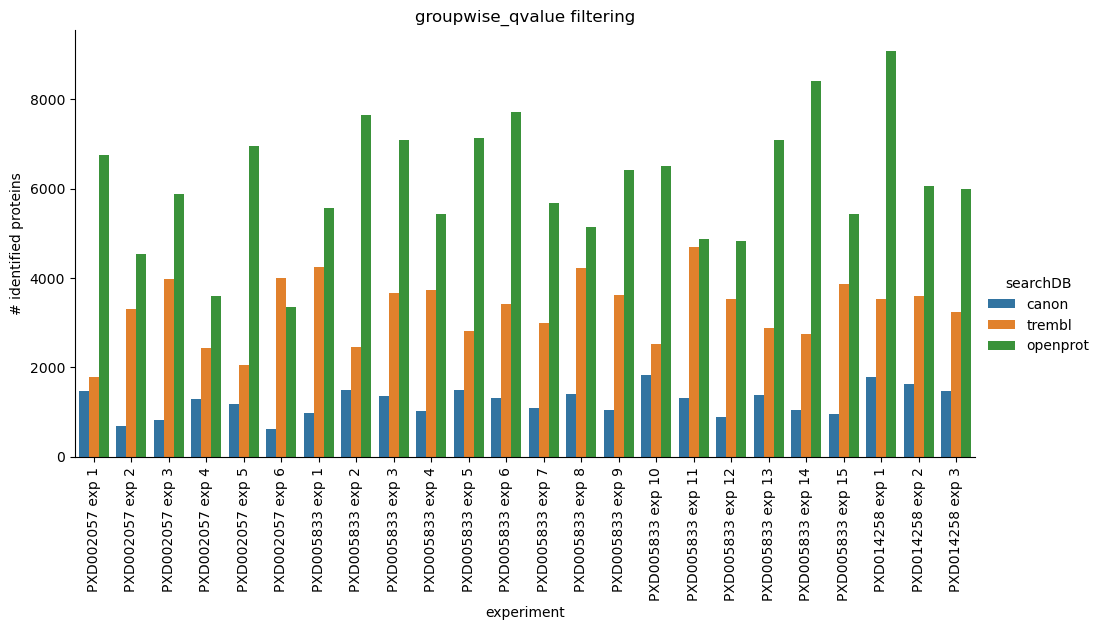

In [24]:
tmp = 'groupwise_qvalue'
combo = combo[(combo[tmp]<.01)&(combo.database=='T')&(combo.isCanonical!='Contam')]
combo.proteins = combo.proteins.str.split(',')
combo = combo.explode('proteins')
combo.drop_duplicates(['proteins','experiment','searchDB'], inplace=True)

sns.catplot(data=combo, kind='count', x='exp_number', hue='searchDB', aspect=2, )#palette=list(project_palette.values()))
plt.xticks(rotation=90)
plt.xlabel('experiment')
plt.ylabel('# identified proteins')
plt.title(f'{tmp} filtering')

#plt.savefig(savefig_path, dpi=300, bbox_inches='tight')